# Prepare Dataset


In [51]:
from __future__ import print_function

import logging
import os
import re

import gensim
import nltk
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from numpy import random
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

In [52]:
data = pd.read_csv(
    "./input/deceptive-opinion-spam-corpus/deceptive-opinion-augmented.csv"
)

In [53]:
df = data.drop(["hotel", "polarity", "source"], axis=1)

In [54]:
df1 = df.sample(frac=1)

In [55]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df1["deceptive"] = label_encoder.fit_transform(df1["deceptive"])

df1["deceptive"].unique()

array([0, 1])

In [56]:
df1.describe()

,deceptive
count,3200.000000
mean,0.500000
std,0.500078
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


# Data preprocessing


In [57]:
from nltk.corpus import stopwords
import re

REPLACE_BY_SPACE_RE = re.compile("[/(){}\[\]\|@,;]")
BAD_SYMBOLS_RE = re.compile("[^0-9a-z #+_]")
STOPWORDS = set(stopwords.words("english"))


def clean_text(text):
    """
    text: a string

    return: modified initial string
    """
    text = text.lower().split()
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+\-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text


df1["text"] = df1["text"].apply(clean_text)

In [58]:
X = df1.text
y = df1.deceptive

In [59]:
X = X.map(lambda a: clean_text(a))

In [60]:
def text_to_wordlist(text):
    # Remove Special Characters
    text = re.sub(r"[^a-z\d ]", " ", text)
    text = re.sub(r"\d+", "_num_", text)
    return text

In [61]:
X = X.map(lambda a: text_to_wordlist(a))

In [62]:
# X_train, y_train for training (70%)
# X_val, y_val for development (15%)
# X_test, y_test for testing (15%)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42
)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42
)  # 15% dev, 15% test

# train, test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [63]:
tokenizer = Tokenizer(
    num_words=None,
    lower=True,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    split=" ",
    char_level=False,
)

In [64]:
tokenizer.fit_on_texts(X)

In [65]:
x_train = tokenizer.texts_to_sequences(X_train)
x_val = tokenizer.texts_to_sequences(X_val)
x_test = tokenizer.texts_to_sequences(X_test)

In [66]:
word_index = tokenizer.word_index

In [67]:
X = tokenizer.texts_to_sequences(X)

In [68]:
vocab_size = len(word_index)
print("Vocab size: {}".format(vocab_size))
longest = max(len(seq) for seq in X)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in X])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in X])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print("Max comment size: {}".format(max_len))

Vocab size: 10210
Longest comment size: 795
Average comment size: 149.5671875
Stdev of comment size: 87.54077541831488
Max comment size: 412


In [69]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [70]:
processed_post_x_train = pad_sequences(
    x_train, maxlen=max_len, padding="post", truncating="post"
)
processed_post_x_val = pad_sequences(
    x_val, maxlen=max_len, padding="post", truncating="post"
)
processed_post_x_test = pad_sequences(
    x_test, maxlen=max_len, padding="post", truncating="post"
)

In [71]:
processed_x_train = pad_sequences(x_train, maxlen=max_len)
processed_x_val = pad_sequences(x_val, maxlen=max_len)
processed_x_test = pad_sequences(x_test, maxlen=max_len)

In [72]:
print("x_train shape:", processed_x_train.shape)
print("x_test shape:", processed_x_test.shape)

x_train shape: (2240, 412)
x_test shape: (480, 412)


In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    LSTM,
    Conv1D,
    MaxPooling1D,
    GlobalMaxPooling1D,
    BatchNormalization,
    Dropout,
    Embedding,
    Flatten,
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [74]:
embeddings_index = {}
f = open(
    os.path.join(
        "./input/glove-global-vectors-for-word-representation", "glove.6B.100d.txt"
    )
)
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float32")
    embeddings_index[word] = coefs
f.close()
print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [75]:
embedding_dim = 100
k = 0
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        k += 1
        embedding_matrix[i] = embedding_vector

In [76]:
# Initate model
model = Sequential()

model.add(
    Embedding(
        vocab_size + 1,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,
    )
)

model.add(LSTM(60, return_sequences=True, name="lstm_layer1"))
model.add(LSTM(30, return_sequences=True, name="lstm_layer2"))
model.add(Conv1D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling1D(3))
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization())

model.add(
    Dense(64, activation="relu", kernel_regularizer=l2(0.17), bias_regularizer=l2(0.01))
)
model.add(Dropout(0.3))
model.add(
    Dense(
        32, activation="sigmoid", kernel_regularizer=l2(0.19), bias_regularizer=l2(0.01)
    )
)
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.summary()

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 412, 100)          1021100   
                                                                 
 lstm_layer1 (LSTM)          (None, 412, 60)           38640     
                                                                 
 lstm_layer2 (LSTM)          (None, 412, 30)           10920     
                                                                 
 conv1d_1 (Conv1D)           (None, 412, 128)          11648     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 137, 128)         0         
 1D)                                                             
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                     

# LSTM-Conv1D


## Train


In [77]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [78]:
filepath = "./results/Conv1D-glove100D-{epoch:02d}-{val_accuracy:.2f}.hdf5"

callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, min_lr=1e-6),
    ModelCheckpoint(
        filepath, monitor="val_accuracy", verbose=1, save_best_only=True, mode="max"
    ),
]

In [79]:
want_load = False
model_checkpoint = "./results/weights-improvement-12-0.88.hdf5"

if want_load:
    model = get_model()
    model.load_weights(model_checkpoint)

In [80]:
history = model.fit(
    processed_x_train,
    y_train,
    validation_data=(processed_x_test, y_val),
    epochs=15,
    batch_size=32,
    callbacks=callbacks,
    verbose=1,
)

Epoch 1/15
70/70 [==============================] - ETA: 0s - loss: 14.4434 - accuracy: 0.5960
Epoch 1: val_accuracy improved from -inf to 0.49167, saving model to ./results\Conv1D-glove100D-01-0.49.hdf5
70/70 [==============================] - 31s 403ms/step - loss: 14.4434 - accuracy: 0.5960 - val_loss: 7.9349 - val_accuracy: 0.4917 - lr: 0.0010
Epoch 2/15
70/70 [==============================] - ETA: 0s - loss: 4.8106 - accuracy: 0.7268
Epoch 2: val_accuracy improved from 0.49167 to 0.51042, saving model to ./results\Conv1D-glove100D-02-0.51.hdf5
70/70 [==============================] - 24s 347ms/step - loss: 4.8106 - accuracy: 0.7268 - val_loss: 2.8690 - val_accuracy: 0.5104 - lr: 0.0010
Epoch 3/15
70/70 [==============================] - ETA: 0s - loss: 1.7900 - accuracy: 0.7884
Epoch 3: val_accuracy improved from 0.51042 to 0.52500, saving model to ./results\Conv1D-glove100D-03-0.52.hdf5
70/70 [==============================] - 27s 390ms/step - loss: 1.7900 - accuracy: 0.7884 - v

## Evaluation


In [83]:
from sklearn.metrics import accuracy_score

In [84]:
def evaluate_model(model, X_test, y_test):
    # Get predictions
    y_pred = model.predict(X_test)
    y_pred_classes = (y_pred > 0.5).astype(int)

    # Calculate test accuracy
    test_accuracy = accuracy_score(y_test, y_pred_classes)
    print(f"\nTest Accuracy: {test_accuracy:.4f}")

    # Print classification report
    print("\nClassification Report:")
    cls_report = classification_report(y_test, y_pred_classes)
    print(cls_report)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"])

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"])

    plt.tight_layout()
    plt.show()

    return (cls_report, test_accuracy)

15/15 [==============================] - 1s 95ms/step

Test Accuracy: 0.8938

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       249
           1       0.86      0.94      0.89       231

    accuracy                           0.89       480
   macro avg       0.90      0.90      0.89       480
weighted avg       0.90      0.89      0.89       480



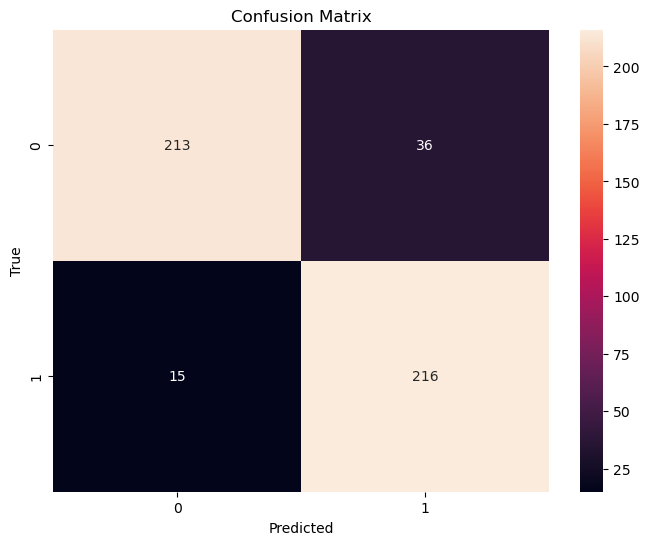

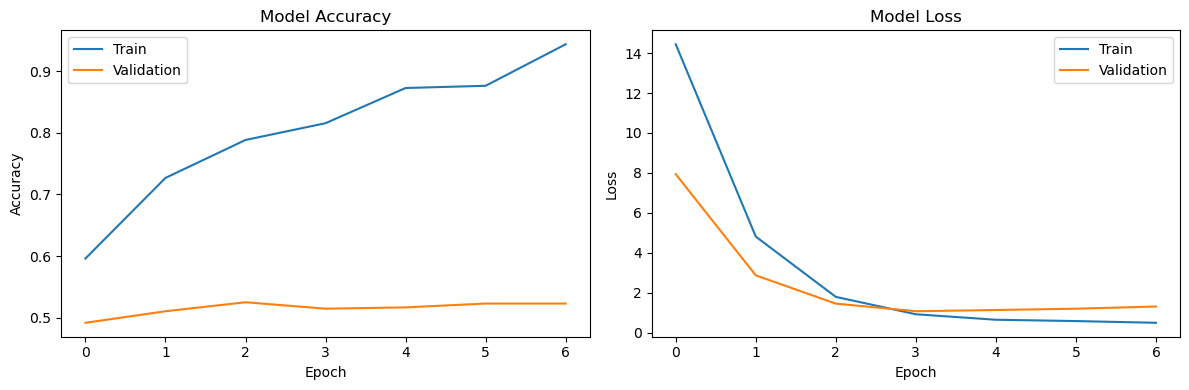

In [85]:
(cls_report, test_accuracy) = evaluate_model(model, processed_x_test, y_test)

### Write Results


In [86]:
res_file = "./results/comparative_analysis.csv"

train_accuracy = round(history.history["accuracy"][-1], 4)
val_accuracy = round(history.history["val_accuracy"][-1], 4)
test_accuracy = round(test_accuracy, 4)

weighted_avg = cls_report[cls_report.find("weighted avg") :]
stats_metrics = weighted_avg.lstrip("weighted avg").split()[:3]

precision = stats_metrics[0]
recall = stats_metrics[1]
f1_score = stats_metrics[2]

with open(res_file, "a") as f:
    f.write(
        f"LSTM-Conv1D-glove100D,N/A,augmented,{train_accuracy},{val_accuracy},{test_accuracy},{precision},{recall},{f1_score}\n"
    )

# CNN GLoVe


## Train


In [87]:
model_glove = Sequential()
model_glove.add(
    Embedding(
        vocab_size + 1,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,
    )
)
model_glove.add(Dropout(0.2))
model_glove.add(
    Conv1D(
        64, 5, activation="relu", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
    )
)
model_glove.add(MaxPooling1D(pool_size=4))
model_glove.add(BatchNormalization())
model_glove.add(LSTM(100, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
model_glove.add(
    Dense(
        1, activation="sigmoid", kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
    )
)

model_glove.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 412, 100)          1021100   
                                                                 
 dropout_6 (Dropout)         (None, 412, 100)          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 408, 64)           32064     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 102, 64)          0         
 1D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 102, 64)          256       
 hNormalization)                                                 
                                                                 
 lstm (LSTM)                 (None, 100)              

In [88]:
model_glove.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [89]:
history = model_glove.fit(
    processed_x_train,
    y_train,
    validation_data=(processed_x_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1,
)

Epoch 1/30
70/70 [==============================] - 7s 73ms/step - loss: 2.2079 - accuracy: 0.6473 - val_loss: 1.3789 - val_accuracy: 0.7292
Epoch 2/30
70/70 [==============================] - 6s 83ms/step - loss: 1.0587 - accuracy: 0.7906 - val_loss: 1.0278 - val_accuracy: 0.7792
Epoch 3/30
70/70 [==============================] - 5s 76ms/step - loss: 0.7678 - accuracy: 0.8522 - val_loss: 0.8527 - val_accuracy: 0.8021
Epoch 4/30
70/70 [==============================] - 5s 75ms/step - loss: 0.5523 - accuracy: 0.9196 - val_loss: 0.9077 - val_accuracy: 0.6271
Epoch 5/30
70/70 [==============================] - 4s 63ms/step - loss: 0.4949 - accuracy: 0.9263 - val_loss: 0.5789 - val_accuracy: 0.8792
Epoch 6/30
70/70 [==============================] - 5s 78ms/step - loss: 0.4314 - accuracy: 0.9496 - val_loss: 0.5250 - val_accuracy: 0.9083
Epoch 7/30
70/70 [==============================] - 6s 80ms/step - loss: 0.3416 - accuracy: 0.9688 - val_loss: 1.3924 - val_accuracy: 0.6125
Epoch 8/30
70

## Evaluation


15/15 [==============================] - 1s 29ms/step

Test Accuracy: 0.9396

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94       249
           1       0.97      0.90      0.93       231

    accuracy                           0.94       480
   macro avg       0.94      0.94      0.94       480
weighted avg       0.94      0.94      0.94       480



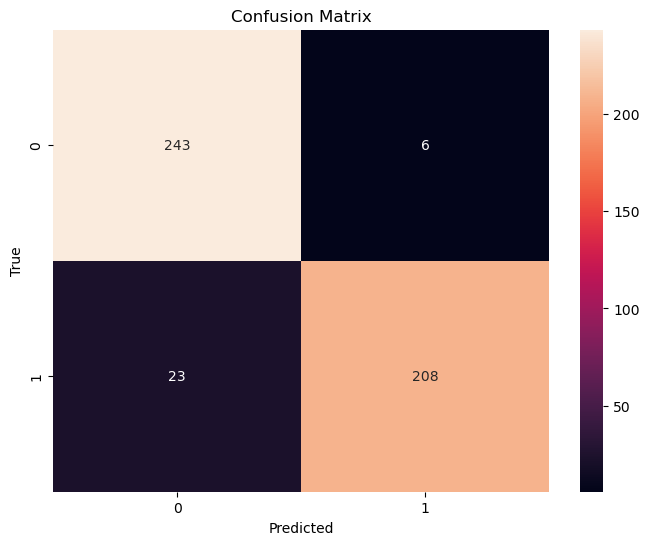

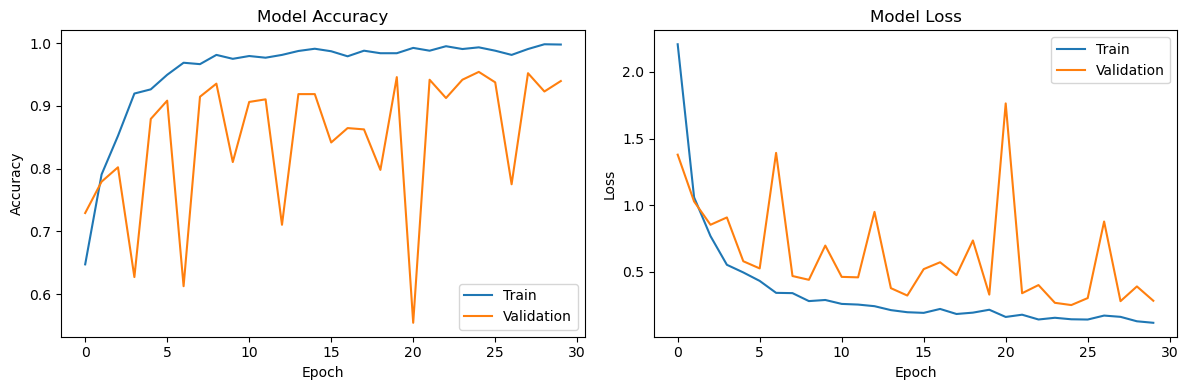

In [90]:
(cls_report, test_accuracy) = evaluate_model(model_glove, processed_x_test, y_test)

### Write Results


In [91]:
res_file = "./results/comparative_analysis.csv"

train_accuracy = round(history.history["accuracy"][-1], 4)
val_accuracy = round(history.history["val_accuracy"][-1], 4)
test_accuracy = round(test_accuracy, 4)

weighted_avg = cls_report[cls_report.find("weighted avg") :]
stats_metrics = weighted_avg.lstrip("weighted avg").split()[:3]

precision = stats_metrics[0]
recall = stats_metrics[1]
f1_score = stats_metrics[2]

with open(res_file, "a") as f:
    f.write(
        f"CNN-glove100D,N/A,augmented,{train_accuracy},{val_accuracy},{test_accuracy},{precision},{recall},{f1_score}\n"
    )

# 2 Layer LSTM


## Train


In [94]:
# Initate model
model_lstm = Sequential()


model_lstm.add(
    Embedding(
        vocab_size + 1,
        embedding_dim,
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,
    )
)

input_shape = embedding_matrix[0].shape


# ,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model_lstm.add(LSTM(60, return_sequences=True, name="lstm_layer1"))
# kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model_lstm.add(LSTM(30, return_sequences=True, name="lstm_layer2"))
# model_lstm.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
# model_lstm.add(MaxPooling1D(3))
# model_lstm.add(GlobalMaxPooling1D())
model_lstm.add(BatchNormalization())
model_lstm.add(Flatten())
model_lstm.add(
    Dense(64, activation="relu", kernel_regularizer=l2(0.17), bias_regularizer=l2(0.01))
)
model_lstm.add(Dropout(0.3))
model_lstm.add(
    Dense(
        32, activation="sigmoid", kernel_regularizer=l2(0.19), bias_regularizer=l2(0.01)
    )
)
model_lstm.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
model.add(Dense(20, activation="relu", input_shape=input_shape))
# model.add(Dense(20, activation='relu'))
model_lstm.add(Dropout(0.3))
model_lstm.add(Dense(1, activation="sigmoid"))
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 412, 100)          1021100   
                                                                 
 lstm_layer1 (LSTM)          (None, 412, 60)           38640     
                                                                 
 lstm_layer2 (LSTM)          (None, 412, 30)           10920     
                                                                 
 batch_normalization_4 (Batc  (None, 412, 30)          120       
 hNormalization)                                                 
                                                                 
 flatten (Flatten)           (None, 12360)             0         
                                                                 
 dense_7 (Dense)             (None, 64)                791104    
                                                      

In [95]:
model_lstm.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [96]:
hist = model_lstm.fit(
    processed_x_train,
    y_train,
    validation_data=(processed_x_test, y_test),
    epochs=15,
    batch_size=32,
    verbose=1,
)

Epoch 1/15
70/70 [==============================] - 28s 368ms/step - loss: 8.5964 - accuracy: 0.5884 - val_loss: 4.1484 - val_accuracy: 0.6542
Epoch 2/15
70/70 [==============================] - 30s 426ms/step - loss: 2.8331 - accuracy: 0.7710 - val_loss: 1.9347 - val_accuracy: 0.7958
Epoch 3/15
70/70 [==============================] - 30s 431ms/step - loss: 1.2981 - accuracy: 0.8487 - val_loss: 0.9858 - val_accuracy: 0.8479
Epoch 4/15
70/70 [==============================] - 30s 432ms/step - loss: 0.6538 - accuracy: 0.9058 - val_loss: 0.5904 - val_accuracy: 0.8792
Epoch 5/15
70/70 [==============================] - 31s 438ms/step - loss: 0.4107 - accuracy: 0.9335 - val_loss: 0.4489 - val_accuracy: 0.8938
Epoch 6/15
70/70 [==============================] - 31s 442ms/step - loss: 0.3006 - accuracy: 0.9567 - val_loss: 0.4511 - val_accuracy: 0.8604
Epoch 7/15
70/70 [==============================] - 31s 445ms/step - loss: 0.2298 - accuracy: 0.9790 - val_loss: 0.4181 - val_accuracy: 0.9250

## Evaluation


15/15 [==============================] - 3s 166ms/step

Test Accuracy: 0.9417

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       249
           1       0.98      0.90      0.94       231

    accuracy                           0.94       480
   macro avg       0.95      0.94      0.94       480
weighted avg       0.94      0.94      0.94       480



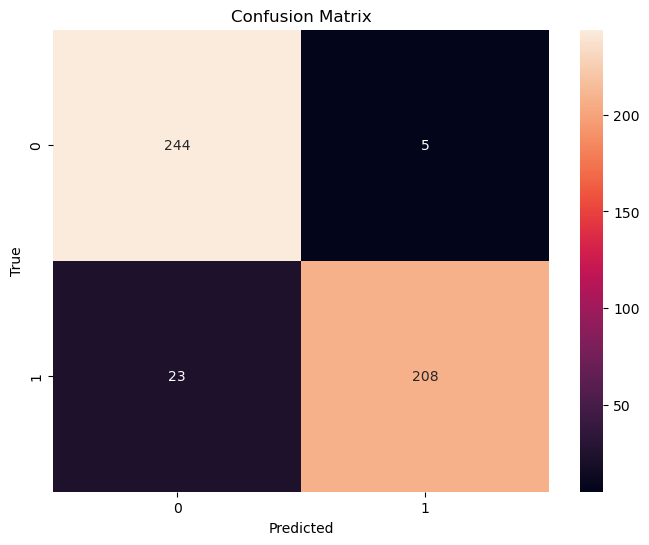

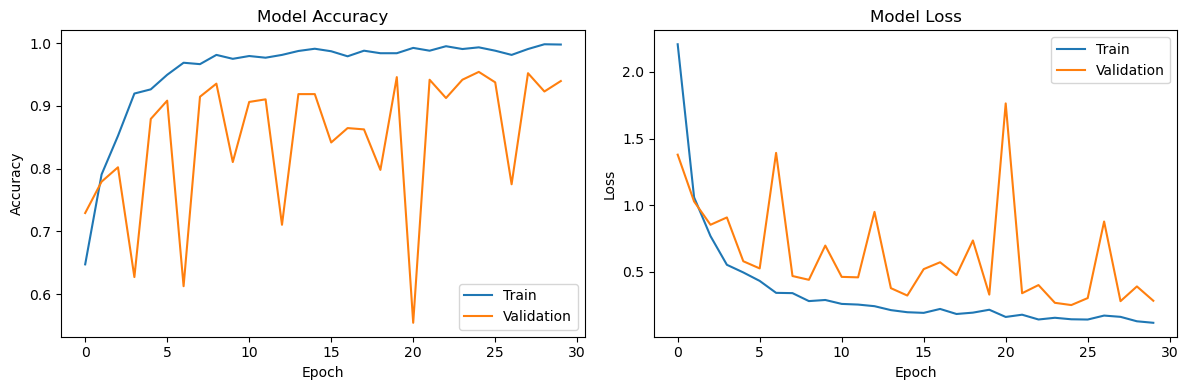

In [97]:
(cls_report, test_accuracy) = evaluate_model(model_lstm, processed_x_test, y_test)

### Write Results


In [98]:
res_file = "./results/comparative_analysis.csv"

train_accuracy = round(history.history["accuracy"][-1], 4)
val_accuracy = round(history.history["val_accuracy"][-1], 4)
test_accuracy = round(test_accuracy, 4)

weighted_avg = cls_report[cls_report.find("weighted avg") :]
stats_metrics = weighted_avg.lstrip("weighted avg").split()[:3]

precision = stats_metrics[0]
recall = stats_metrics[1]
f1_score = stats_metrics[2]

with open(res_file, "a") as f:
    f.write(
        f"2-layer-LSTM-glove100D,N/A,augmented,{train_accuracy},{val_accuracy},{test_accuracy},{precision},{recall},{f1_score}\n"
    )